In [ ]:
pip install praat-parselmouth

     |████████████████████████████████| 9.0MB 2.4MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + "Colab Notebooks/sound"

In [ ]:
import glob
import re #reg express.
import os
import tqdm #te quiero demas, visualiza progresso dos loops
import numpy as np
import pandas as pd
import scipy
import librosa
import matplotlib.pyplot as plt

import parselmouth 
import statistics


from parselmouth.praat import call
from scipy.stats.mstats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
#remover os audios com as 3 vogais juntas
for sound in glob.glob(base_dir + "/patologico/*iau.wav"):
  os.remove(sound)

In [ ]:
#fazer para todas as pastas
for sound in glob.glob(base_dir + "/saudavel/*iau.wav"):
  os.remove(sound)

Agora measurePitch() é uma função que chama vários objetos do praat via parselmouth, e calcula vários tipos do jitter e do shimmer, assim como medidas da F0 e HNR

In [ ]:
def measurePitch(voiceID, f0min, f0max, unit):
    sound = parselmouth.Sound(voiceID) # read the sound
    duration = call(sound, "Get total duration") # duration
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max) #create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, f0min, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    
    return duration, meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer

Aqui plota-se a variância cumulada pelo número de componentes, e printa o número mínimo de comp. que explica mais de 98% da variância cumulada. Ao final retorna-se o valor de PCA com 2 componentes apenas (só por simplicidade)

In [ ]:
def runPCA(df):
    # z-score the Jitter and Shimmer measurements
    measures = ['localJitter', 'localabsoluteJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter',
                'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer']
    x = df.loc[:, measures].values #pega as colunas da lista 'measures' na planilha
    x = StandardScaler().fit_transform(x)
    pca = PCA().fit(x)
    varCumulada = np.cumsum(pca.explained_variance_ratio_) #variância cumulada pelo número de componentes
    plt.plot(varCumulada)
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

    n_components = np.argmax(varCumulada > 0.98) + 1 #pegamos qual índice do nosso vetor corresponde a mais de 98% da var., soma 1 pq começa em 0
    print("Componentes: ", n_components, "Var: ", varCumulada[n_components - 1])
    principalComponents = PCA(n_components=2).fit_transform(x) #mudar 2 para n_components se for pegar os comp. > 98%
    principalDf = pd.DataFrame(data = principalComponents, columns = ['JitterPCA', 'ShimmerPCA'])
    return principalDf

In [ ]:
# cria listas das features
label = [] #classe (saudávelxpatológica)
vocal = [] #vogal falada
file_list = []
duration_list = []
mean_F0_list = []
sd_F0_list = []
hnr_list = []
localJitter_list = []
localabsoluteJitter_list = []
rapJitter_list = []
ppq5Jitter_list = []
ddpJitter_list = []
localShimmer_list = []
localdbShimmer_list = []
apq3Shimmer_list = []
aqpq5Shimmer_list = []
apq11Shimmer_list = []
ddaShimmer_list = []

Agora os 2 laços abaixo iteram todos os .wav no diretório, e pra cada arquivo de áudio, armazena as features dele nas listas criadas acima. **Importante**: os labels serão 0 para **saudáveis** e 1 para **patológicos**, e o código de cada vogal será **0, 1, 2** para **"a", "i", "u"**, respectivamente.

In [ ]:
# Go through all the wave files in the folder and measure all the acoustics
# casos saudáveis
saudavel_dir = base_dir + "/saudavel"

for wave_file in glob.glob(saudavel_dir + "/*.wav"):
    sound = parselmouth.Sound(wave_file)
    (duration, meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, 
     localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurePitch(
        sound, 75, 300, "Hertz")
     
    label.append(0) #0 é saudável
    if re.search("[0-9]*a_n.wav$", wave_file): #se é "a"
      vocal.append(0)
    elif re.search("[0-9]*i_n.wav$", wave_file): #se é "i"
      vocal.append(1)
    else: #se é "u"
      vocal.append(2)
    file_list.append(wave_file) # make an ID list
    duration_list.append(duration) # make duration list
    mean_F0_list.append(meanF0) # make a mean F0 list
    sd_F0_list.append(stdevF0) # make a sd F0 list
    hnr_list.append(hnr) #add HNR data
    
    # add raw jitter and shimmer measures
    localJitter_list.append(localJitter)
    localabsoluteJitter_list.append(localabsoluteJitter)
    rapJitter_list.append(rapJitter)
    ppq5Jitter_list.append(ppq5Jitter)
    ddpJitter_list.append(ddpJitter)
    localShimmer_list.append(localShimmer)
    localdbShimmer_list.append(localdbShimmer)
    apq3Shimmer_list.append(apq3Shimmer)
    aqpq5Shimmer_list.append(aqpq5Shimmer)
    apq11Shimmer_list.append(apq11Shimmer)
    ddaShimmer_list.append(ddaShimmer)

In [ ]:
# repetir o for para a pasta patológica
patologica_dir = base_dir + "/patologico"

for wave_file in glob.glob(patologica_dir + "/*.wav"):
    sound = parselmouth.Sound(wave_file)
    (duration, meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, 
     localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurePitch(
        sound, 75, 300, "Hertz")
     
    label.append(1) #1 é patológica
    if re.search("[0-9]*a_n.wav$", wave_file): #se é "a"
      vocal.append(0)
    elif re.search("[0-9]*i_n.wav$", wave_file): #se é "i"
      vocal.append(1)
    else: #se é "u"
      vocal.append(2)
    file_list.append(wave_file) # make an ID list
    duration_list.append(duration) # make duration list
    mean_F0_list.append(meanF0) # make a mean F0 list
    sd_F0_list.append(stdevF0) # make a sd F0 list
    hnr_list.append(hnr) #add HNR data
    
    # add raw jitter and shimmer measures
    localJitter_list.append(localJitter)
    localabsoluteJitter_list.append(localabsoluteJitter)
    rapJitter_list.append(rapJitter)
    ppq5Jitter_list.append(ppq5Jitter)
    ddpJitter_list.append(ddpJitter)
    localShimmer_list.append(localShimmer)
    localdbShimmer_list.append(localdbShimmer)
    apq3Shimmer_list.append(apq3Shimmer)
    aqpq5Shimmer_list.append(aqpq5Shimmer)
    apq11Shimmer_list.append(apq11Shimmer)
    ddaShimmer_list.append(ddaShimmer)

In [ ]:
print(len(label))

255


Aqui com as features já em mãos, executa então o PCA e salva os resultados numa planilha.

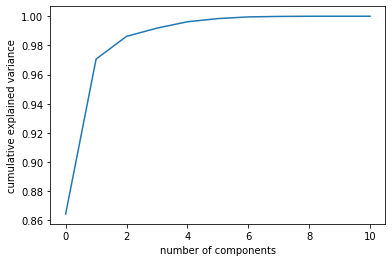

Componentes:  3 Var:  0.9862169921857785


,classe,vogal,voiceID,duration,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
109,1,0,/content/gdrive/My Drive/Colab Notebooks/sound...,0.981927,123.403680,1.360836,12.250319,0.021621,0.000175,0.013349,0.011405,0.040046,0.206383,1.818937,0.124185,0.105225,0.108850,0.372554,7.082035,-3.370931
116,1,1,/content/gdrive/My Drive/Colab Notebooks/sound...,1.357370,131.565217,2.869925,25.837673,0.004853,0.000037,0.002271,0.002721,0.006812,0.013945,0.124499,0.005749,0.008730,0.016218,0.017246,-1.874339,0.668953
115,1,2,/content/gdrive/My Drive/Colab Notebooks/sound...,1.225442,135.781013,3.990357,31.743418,0.003326,0.000024,0.001296,0.001941,0.003889,0.013536,0.117192,0.005647,0.008848,0.014558,0.016941,-2.070279,0.501045
165,1,0,/content/gdrive/My Drive/Colab Notebooks/sound...,2.193243,157.340605,24.435349,16.619648,0.006666,0.000042,0.003759,0.004026,0.011276,0.142042,1.242545,0.083253,0.080725,0.089370,0.249760,3.170859,-3.369958
168,1,1,/content/gdrive/My Drive/Colab Notebooks/sound...,2.079161,172.147111,1.342828,22.754654,0.002308,0.000013,0.000993,0.001278,0.002979,0.010182,0.088776,0.004846,0.006319,0.010435,0.014537,-2.296380,0.506211
170,1,2,/content/gdrive/My Drive/Colab Notebooks/sound...,2.250612,184.218502,2.191007,29.997868,0.002323,0.000013,0.001010,0.001257,0.003029,0.022414,0.187099,0.012687,0.012269,0.016398,0.038061,-1.852292,0.112012
172,1,0,/content/gdrive/My Drive/Colab Notebooks/sound...,1.131655,135.122156,6.435389,22.841743,0.003098,0.000023,0.001245,0.001572,0.003736,0.051568,0.443130,0.029956,0.032088,0.034838,0.089869,-0.634326,-0.830187
176,1,1,/content/gdrive/My Drive/Colab Notebooks/sound...,1.551995,147.003807,2.679738,28.070259,0.002140,0.000015,0.000915,0.001097,0.002746,0.011378,0.098737,0.005342,0.006886,0.011729,0.016025,-2.266667,0.450999
175,1,2,/content/gdrive/My Drive/Colab Notebooks/sound...,0.999660,146.837304,2.830017,27.626567,0.003201,0.000022,0.001546,0.002045,0.004637,0.022533,0.199391,0.010235,0.014396,0.022016,0.030706,-1.708782,0.201486
127,1,0,/content/gdrive/My Drive/Colab Notebooks/sound...,2.177075,91.813951,1.961123,16.483569,0.008431,0.000092,0.004721,0.004972,0.014163,0.073182,0.646901,0.040350,0.048504,0.059111,0.121051,0.981704,-0.901341


In [ ]:
# Add the data to Pandas
df = pd.DataFrame(np.column_stack([label, vocal, duration_list, mean_F0_list, sd_F0_list, hnr_list, 
                                   localJitter_list, localabsoluteJitter_list, rapJitter_list, 
                                   ppq5Jitter_list, ddpJitter_list, localShimmer_list, 
                                   localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, 
                                   apq11Shimmer_list, ddaShimmer_list]),
                                   columns=['classe', 'vogal', 'duration', 'meanF0Hz', 'stdevF0Hz', 'HNR', 
                                            'localJitter', 'localabsoluteJitter', 'rapJitter', 
                                            'ppq5Jitter', 'ddpJitter', 'localShimmer', 
                                            'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 
                                            'apq11Shimmer', 'ddaShimmer'])


df.replace("nan", np.NaN, inplace=True)
df.dropna(inplace=True)


#pcaData = runPCA(df) # Run jitter and shimmer PCA
#df = pd.concat([df.reset_index(drop=True), pcaData.reset_index(drop=True)], axis=1) # Add PCA data, reseta index para conseguir alinhar no concat

# reload the data so it's all numbers
df.to_csv(base_dir + "/processed_results.csv", index=False)
df = pd.read_csv('processed_results.csv', header=0)
df.sort_values('voiceID').head(15)

**[SELEÇÂO DE CARAC.]**

In [ ]:
TRAIN = np.array(df)

X = TRAIN[:, 1:]
Y = TRAIN[:, 0]

X[:, :] -= np.min(X[:, :], axis=0) #Scaling
X[:, :] /= np.max(X[:, :], axis=0)

**[SELEÇÂO PARACONSISTENTE]**

In [ ]:
import paraconsistentLIB.py

BestsIndexes = []
BestsDists = []
number_of_classes=2
number_of_feature_vectors_in_class = [0] * number_of_classes #syntax for list init
number_of_feature_vectors_in_class[0]=(Y == 0).sum() #saudável
number_of_feature_vectors_in_class[1]=(Y == 1).sum() #patológico

c = X[:, :].flatten()
print(BestParaconsistent(number_of_classes, number_of_feature_vectors_in_class,\
dimension_of_each_feature_vector, c, verbose=False) )

**[SELEÇÃO UNIVARIADA] - considerando teste de qui-quadrado** 